In [1]:
import sys

sys.path.append('../src')
from dae import VQAE
from lda import GibbsLDA, PyroLDA
from ncp import NCP
from sim import make_dataset
from slda import GibbsSLDA
from utils import show_dataset

### Latent Dirichlet Allocation

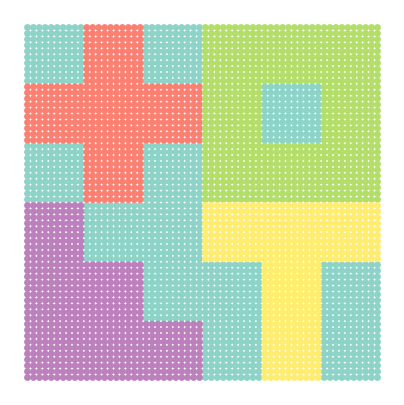

In [2]:
data, labels = make_dataset(return_tensor=True)
show_dataset(data, labels)

LDA: 100%|██████████| 1000/1000 [00:08<00:00, 113.63it/s]


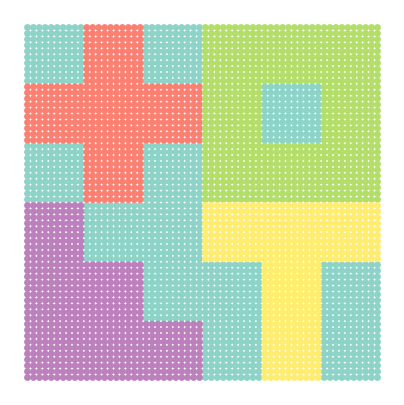

In [3]:
model = PyroLDA(5)
topics = model.fit_predict(data[:, 3:])
show_dataset(data, topics)

LDA: 100%|██████████| 100/100 [00:44<00:00,  2.27it/s]


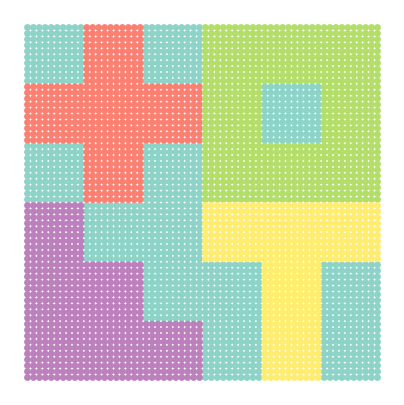

In [4]:
model = GibbsLDA(5)
topics = model.fit_predict(data[:, 3:])
show_dataset(data, topics)

### Spatial Latent Dirichlet Allocation

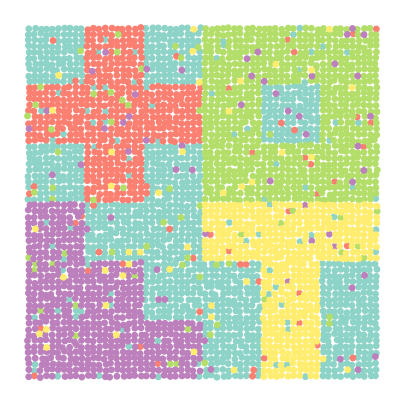

In [5]:
data, labels = make_dataset(wiggle=.1, mix=.1)
show_dataset(data, labels)

SLDA: 100%|██████████| 200/200 [00:44<00:00,  4.45it/s]


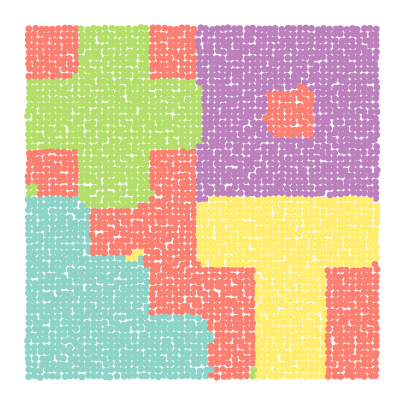

In [6]:
model = GibbsSLDA()
topics = model.fit_predict(data)
show_dataset(data, topics)

### Vector Quantized Autoencoder

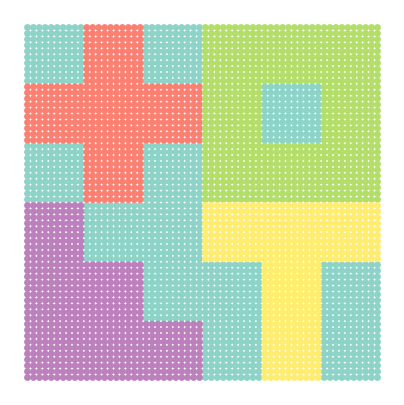

In [7]:
data, labels = make_dataset(return_tensor=True)
show_dataset(data, labels)

QAE: 100%|██████████| 100/100 [00:03<00:00, 33.30it/s]


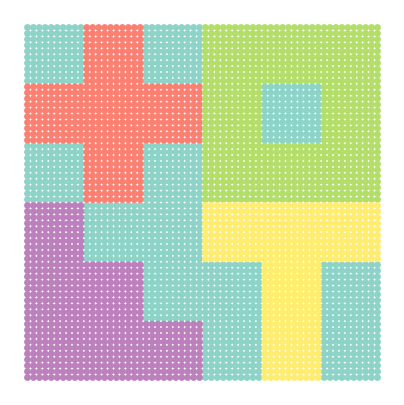

In [8]:
model = VQAE()
topics = model.fit_predict(data)
show_dataset(data, topics)

### Neural Clustering Process

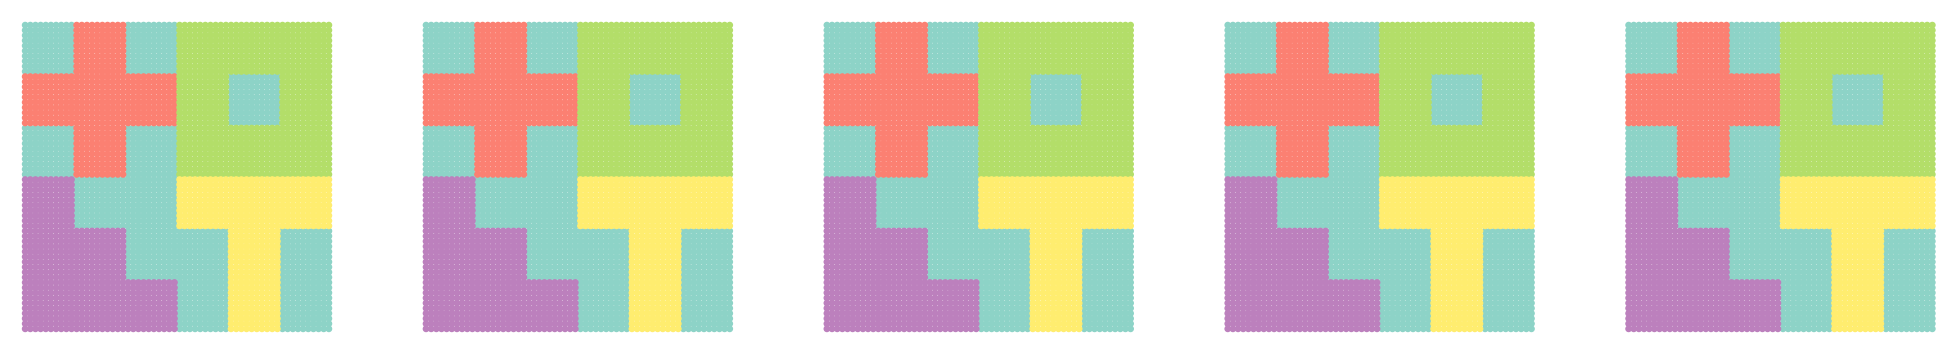

In [9]:
N_DATASETS = 4
TEMPLATE = ('polygons',) + ('polygons',)*N_DATASETS
BLOCK_SIZE = (10, 10)

data, labels = make_dataset(TEMPLATE, n_features=3, block_size=BLOCK_SIZE, return_tensor=True)

X = data[data[data[:, 0] == 0].shape[0]:]
X = X.view(N_DATASETS, X.shape[0]//N_DATASETS, X.shape[-1])[..., 3:]
y = labels[data[data[:, 0] == 0].shape[0]:data[data[:, 0] == 0].shape[0] + X.shape[1]]
z = data[:data[data[:, 0] == 0].shape[0]]
z_locations, z_features = z[:, :3], z[None][..., 3:]

show_dataset(data, labels, sectioned=True)

NCP: 100%|██████████| 200/200 [01:38<00:00,  2.04it/s]


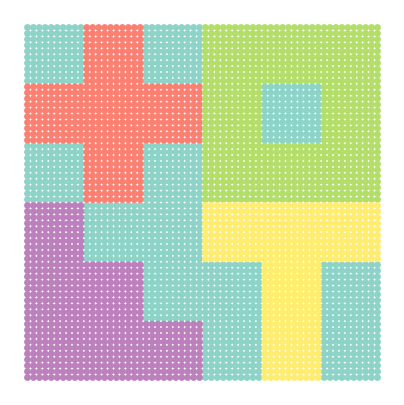

In [10]:
model = NCP()
topics = model.fit(X, y)(z_features)
show_dataset(z_locations, topics)